<a href="https://colab.research.google.com/github/Geoffrey-Harper/OilPrices_S02_emissions/blob/main/GEOG606.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


import ee
ee.Authenticate()

In [3]:
ee.Initialize(project='ee-geoffreycgh') # Replace with your default project ID - find at https://console.cloud.google.com/

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Oil prices impact on SO2 Aerosls in the Eastern USA


When carbon is burned it not only relases CO2 but SO2 and powerful pollutent but also something that can be traced in the atmosphere.

## Background

USA is one of the biggest contributors to global emissions in the world (SOURCE IPCC), in particular the eastern US seaboard is historically the largest area of SO2 emissions (Stevens 2016).

When CO2 is burned it releases SO2 a powerful pollutant. However this pollutant rains out quickly. Historically lower oil prices have helped drive its demand and prompted its use (https://www.imf.org/en/Blogs/Articles/2015/12/02/the-price-of-oil-and-the-price-of-carbon)

## Hypothesis:

High oil prices result in more burning of coal power plants and thus more SO2 burning.

## First order questions

Is there a direct link between high oil prices and high SO2 amount in the atmosphere?

## Data sets we will use

 - Sentinel-5P NRTI SO2: Near Real-Time Sulfur Dioxide

 Satellite that went live in 2018, that tracks the density of SO2 in an air column

 - West texas crude oil prices

 The main driver in oil and gas prices around the world, coal usage is driven by high oil pirces as it is used as a substitue when the oil pirce is high


## Methods

In order to analyze this data we will use Google Earth Engine to extract SO2 air column density over the region of the USA which historically creates the most SO2, describe by the bounding box.

Lattitude_1 = 30.1

Longittude_1 = -92.5

Lattitude_2 = 50.1

Longittude_2 = -72.5

In [5]:
import geemap

# Define the bounding box coordinates.
lat1 = 30.1
lon1 = -92.5
lat2 = 50.1
lon2 = -72.5

# Create a geometry object representing the bounding box.
bbox = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

# Create a map centered on the bounding box.
map = geemap.Map(center=[(lat1 + lat2) / 2, (lon1 + lon2) / 2], scale=4)

# Add the bounding box to the map.
map.addLayer(bbox, {'color': 'red'}, 'Bounding Box')

# Display the map.
map

Map(center=[40.1, -82.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

To analysis our date we will preform the folloiwng:

1) Look at scatter plot of (roi) for oil price and SO2 density

2) Compare histograms between oil price and SO2 density

3) do a time series comparison between the two on the same x-axis, to see if we can find some trends

4) Can we find a linear regression such that oil price will be inversly propotional to SO2?

5) Comute some statsitcs regarding our linear regression

6) Summarize our data and our regressions test statistics

# Gathering our datasets

Before we do analysis we need to get our data in a form we can run analysis in.

## Collecting SO2 air column density

In [ ]:
## collect the SO2 column density band image collection
SO2_density = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_SO2')\
        .select('SO2_column_number_density')

In [ ]:
SO2_density.first().bandNames().getInfo()

['SO2_column_number_density']

In [ ]:
#As according to https://dges.carleton.ca/CUOSGwiki/index.php/Time_Series_Analysis_using_Google_Earth_Engine_and_Google_Colab

# This function is used to define a custom reducer that allows one to collect
# a time series of feature data

# this is done using functional programming

# Functional programming decomposes a problem into a set of functions.

# the first function defines what values will be used in the map function
# then the second function defines how the mapping function will execute

# Define a function (and embedded function) for reducing a region for charting
# See the function descriptions defined in red within the functions

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.median(),
                                  scale=1113.2,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  """

  def reduce_region_function(img):
    """
      Function returns
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [ ]:
#define function that can be used for mapping
reduce_SO2_density = create_reduce_region_function(
    geometry=bbox, reducer=ee.Reducer.median())


In [ ]:
# we want to apply accross an image collection filtered by yearly ranges so we extract the available years in the collection
years = SO2_density.aggregate_array('system:time_start') \
  .map(lambda date: ee.Date(date).get('year')) \
  .distinct() \
  .getInfo()

print(years)

[2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [ ]:
# Create a dictionary of date filters with each data representing a ee.Date object
date_filters = {}
for year in years:
  start_date = ee.Date.fromYMD(year, 1, 1)
  end_date = start_date.advance(1, 'year')
  date_filters[year] = ee.Filter.date(start_date, end_date)


In [ ]:
# Convert the image collection to a feature collection with the reducer function
## Because our data collection is so large we have to do batch processing
## we run a batch process to get all the image instances as given by a year
## Then we create one large processed feature collection that contains all our data across the entire data period


SO2_fcs_per_year = []

#for each year do the following
# load the image collection
# filter it so that it only contains images from a given yearly range
# apply our reducer function to extract the SO2_density from each image within the yearly range
# add it to our final feature collection that will contain all entries

for year in years:

  SO2_density = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_SO2')\
        .select('SO2_column_number_density')

  SO2_density_per_year = SO2_density.filter(date_filters[year])

  SO2_stat_fc = ee.FeatureCollection(SO2_density_per_year.map(reduce_SO2_density))

  SO2_stat_fc = SO2_stat_fc.filter(ee.Filter.notNull(SO2_density_per_year.first().bandNames()))
  SO2_fcs_per_year.append(SO2_stat_fc)

  print(year)
  print(SO2_density_per_year.first().date().getInfo())



2018
{'type': 'Date', 'value': 1538467077000}
2019
{'type': 'Date', 'value': 1546302525000}
2020
{'type': 'Date', 'value': 1577836862000}
2021
{'type': 'Date', 'value': 1609515299000}
2022
{'type': 'Date', 'value': 1640995359000}
2023
{'type': 'Date', 'value': 1672533239000}
2024
{'type': 'Date', 'value': 1704097101000}


In [ ]:
# Define a function to transfer feature properties to a dictionary.
# We use this to convert our earth engine object (reduced image collection) to a
# collection of properties and their values

def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)


In [ ]:
SO2_dfs = []

#for each feature collection do the following
# get the feature collection
# convert it to a dictionary
# contert dictionary to pandas data frame
# add it to our final data frame that we will use for time series analysis

for i in range(len(SO2_fcs_per_year)):
  #image
  image = SO2_fcs_per_year[i]
  # Convert the feature collection to a dictionary, and lazy load our SO2 density data
  SO2_stat_fc = fc_to_dict(image).getInfo()

  SO2_df = pd.DataFrame(SO2_stat_fc)
  SO2_df['millis'] = pd.to_datetime(SO2_df['millis'], unit='ms')
  SO2_df.set_index('millis', inplace=True)

  SO2_dfs.append(SO2_df)


In [ ]:
#merge all dataframes together
SO2_df_final = pd.concat(SO2_dfs, axis=0)

#save to csv
SO2_df_final.to_csv('/content/drive/MyDrive/SO2_df_final.csv')

In [6]:
#load data set
SO2_df_final = pd.read_csv('/content/drive/MyDrive/SO2_df_final.csv',index_col=0)

In [7]:
#set millis to index
SO2_df_final.index = pd.to_datetime(SO2_df_final.index)
SO2_df_final.index

DatetimeIndex(['2018-10-02 16:27:57', '2018-10-02 17:57:57',
               '2018-10-02 18:02:58', '2018-10-02 18:07:58',
               '2018-10-02 19:47:58', '2018-10-03 17:42:58',
               '2018-10-03 17:47:58', '2018-10-03 19:27:57',
               '2018-10-04 17:22:58', '2018-10-04 17:27:57',
               ...
               '2024-10-06 16:45:44', '2024-10-06 16:50:44',
               '2024-10-06 18:25:44', '2024-10-06 18:30:44',
               '2024-10-06 20:05:45', '2024-10-06 20:10:44',
               '2024-10-07 18:05:44', '2024-10-07 18:10:44',
               '2024-10-07 19:45:44', '2024-10-07 19:50:44'],
              dtype='datetime64[ns]', name='millis', length=8949, freq=None)

In [8]:
#drop system:index col
SO2_df_final = SO2_df_final.drop(columns=['system:index'])


In [9]:
#resample for month
SO2_df_final_month = SO2_df_final.resample("QE").mean()


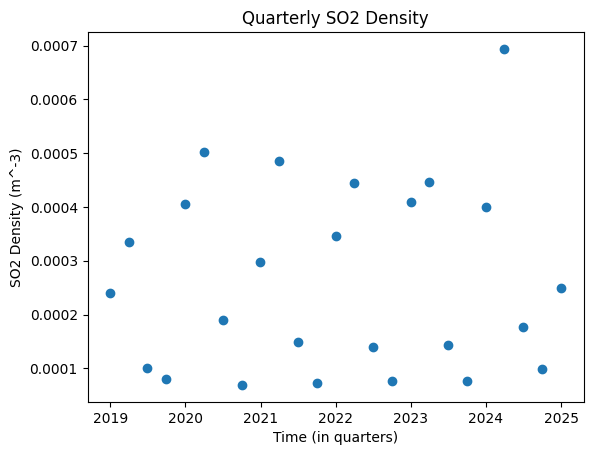

In [13]:
# look at an inital scatter plot

plt.scatter(SO2_df_final_month.index, SO2_df_final_month['SO2_column_number_density'])
plt.xlabel('Time (in quarters)')
plt.ylabel('SO2 Density (m^-3)')
plt.title('Quarterly SO2 Density')

plt.show()

# Gather West Texas Oil Price

In [10]:
import yfinance as yf #yahoo finance provides great access to stock prices

In [11]:
OIL_ticker = yf.Ticker('WTI') #we choose the stock West Texas Intermediate

In [12]:
#create pandas data frame from 2018 to now as our satillite data starts in 2018
# we want to match Oil prices time stamps with SO2 density time stamps
OIL_df = OIL_ticker.history(start="2018-01-01")

In [13]:
OIL_quarterly = OIL_df.resample("QE").mean() #resample it quarterly

In [14]:
OIL_quarterly.index = OIL_quarterly.index.date

In [15]:
OIL_quarterly.index

Index([2018-03-31, 2018-06-30, 2018-09-30, 2018-12-31, 2019-03-31, 2019-06-30,
       2019-09-30, 2019-12-31, 2020-03-31, 2020-06-30, 2020-09-30, 2020-12-31,
       2021-03-31, 2021-06-30, 2021-09-30, 2021-12-31, 2022-03-31, 2022-06-30,
       2022-09-30, 2022-12-31, 2023-03-31, 2023-06-30, 2023-09-30, 2023-12-31,
       2024-03-31, 2024-06-30, 2024-09-30, 2024-12-31],
      dtype='object')

## Merge our data

At this point we might as well merge our data so that it has consitent time stamps between the two. As we are doing time series analysis on them

In [16]:
#join on index
df = pd.merge(OIL_quarterly, SO2_df_final_month, left_index=True, right_index=True)

In [17]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SO2_column_number_density
2018-12-31,6.382523,6.556903,6.113453,6.288145,3.259341e+06,0.0,0.0,0.000240
2019-03-31,5.319486,5.462951,5.196678,5.348857,2.689666e+06,0.0,0.0,0.000335
2019-06-30,5.344213,5.438590,5.201396,5.305618,2.377013e+06,0.0,0.0,0.000100
2019-09-30,4.528098,4.655609,4.384591,4.502258,2.648012e+06,0.0,0.0,0.000080
2019-12-31,4.363672,4.481801,4.276614,4.379976,2.371445e+06,0.0,0.0,0.000406


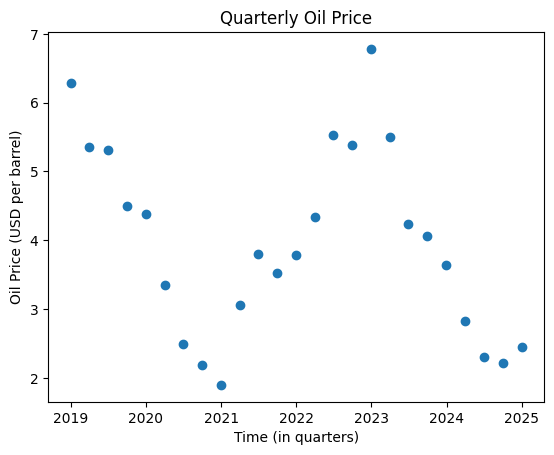

In [ ]:
#lets look at our Oil Prices as a scatter plot
plt.scatter(df.index, df['Close'])
plt.xlabel('Time (in quarters)')
plt.ylabel('Oil Price (USD per barrel)')
plt.title('Quarterly Oil Price')
plt.show()

#Create histograms of Oil and SO2 density

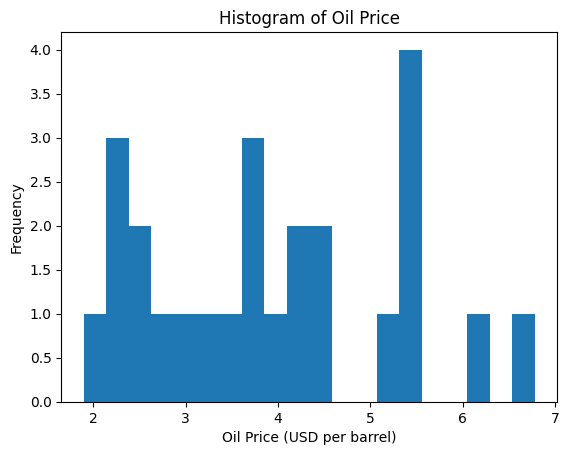

In [ ]:
#create histogram of oil price
plt.hist(df['Close'], bins=20)
plt.xlabel('Oil Price (USD per barrel)')
plt.ylabel('Frequency')
plt.title('Histogram of Oil Price')
plt.show()

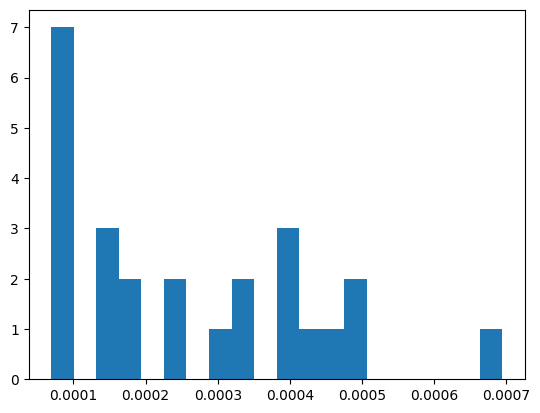

In [ ]:
plt.hist(df['SO2_column_number_density'], bins=20)
plt.show()

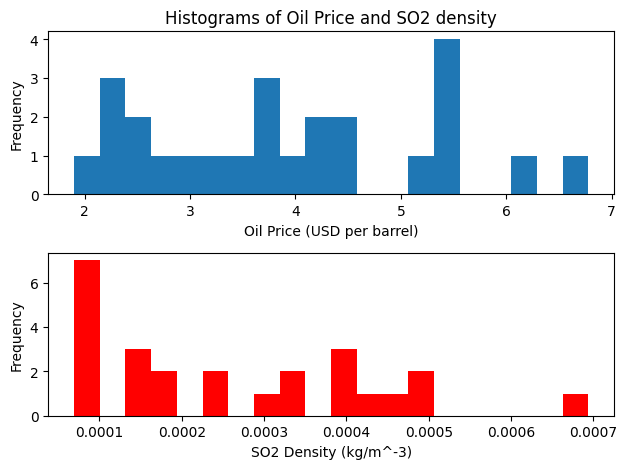

In [ ]:
#make subplot of both historgrams next to each other

plt.subplot(2,1,1)
plt.hist(df['Close'], bins=20)
plt.xlabel('Oil Price (USD per barrel)')
plt.ylabel('Frequency')
plt.title("Histograms of Oil Price and SO2 density")

plt.subplot(2,1,2)
plt.hist(df['SO2_column_number_density'], color = "red",bins=20)
plt.xlabel('SO2 Density (kg/m^-3)')
plt.ylabel('Frequency')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/histograms.pdf')

plt.show()

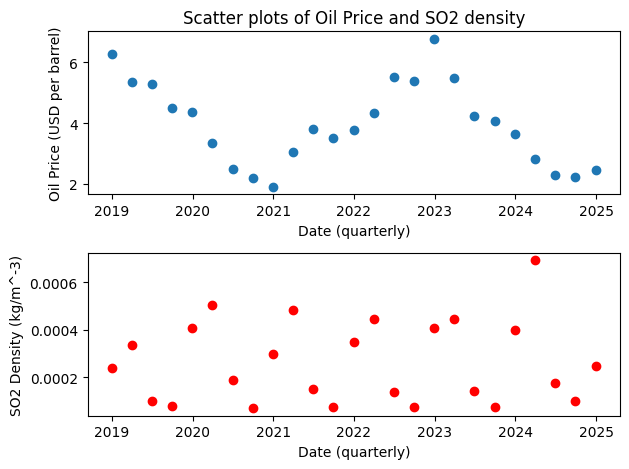

In [ ]:
#scatter plot of both data sets in subplot
#make subplot of both historgrams next to each other

plt.subplot(2,1,1)
plt.scatter(df.index,df['Close'])
plt.ylabel('Oil Price (USD per barrel)')
plt.xlabel('Date (quarterly)')
plt.title("Scatter plots of Oil Price and SO2 density")

plt.subplot(2,1,2)
plt.scatter(df.index,df['SO2_column_number_density'], color = "red")
plt.ylabel('SO2 Density (kg/m^-3)')
plt.xlabel('Date (quarterly)')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/scatter_plot.pdf')


plt.show()



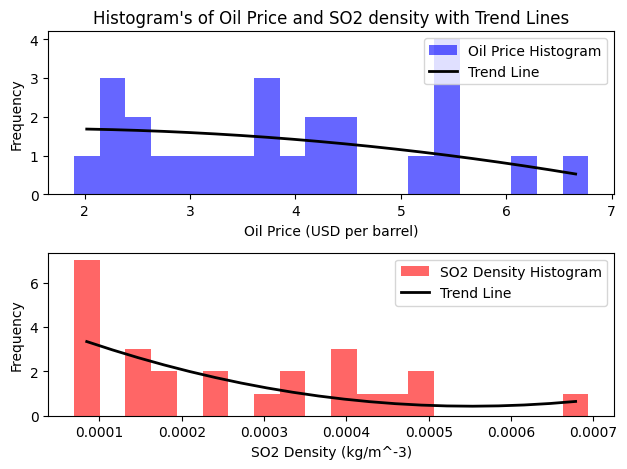

In [ ]:
import numpy as np

plt.subplot(2, 1, 1)
# Oil Price Histogram with Trend Line
data = df['Close']
n, bins, patches = plt.hist(data, bins=20, alpha=0.6, color='b', label='Oil Price Histogram')

# Calculate the centers of the bins
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Fit a polynomial trend line to the histogram
degree = 2
coefficients = np.polyfit(bin_centers, n, degree)
trend_line = np.polyval(coefficients, bin_centers)

plt.plot(bin_centers, trend_line, 'k', linewidth=2, label='Trend Line')

plt.xlabel('Oil Price (USD per barrel)')
plt.ylabel('Frequency')
plt.title("Histogram's of Oil Price and SO2 density with Trend Lines")
plt.legend()

plt.subplot(2, 1, 2)
# SO2 Density Histogram with Trend Line
data = df['SO2_column_number_density']
#we set transparacy value of our histogram using alpha value
n, bins, patches = plt.hist(data, bins=20, alpha=0.6, color='r', label='SO2 Density Histogram')

# Calculate the centers of the bins
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Fit a polynomial trend line to the histogram
degree = 2  # You can adjust the degree of the polynomial
coefficients = np.polyfit(bin_centers, n, degree)
trend_line = np.polyval(coefficients, bin_centers)

plt.plot(bin_centers, trend_line, 'k', linewidth=2, label='Trend Line')

plt.xlabel('SO2 Density (kg/m^-3)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

#Time series plot one x axis two y axies

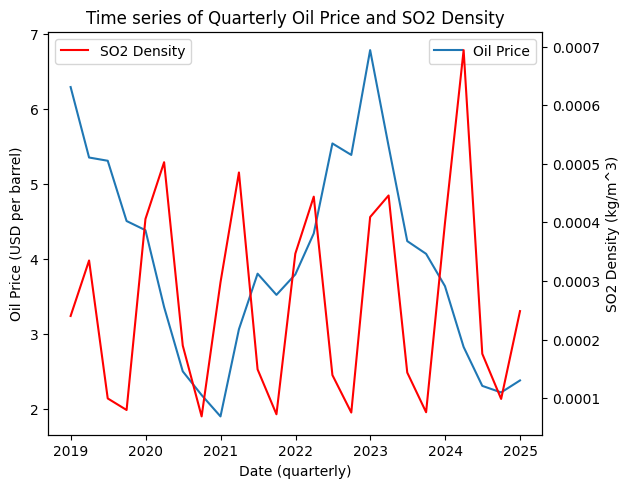

In [20]:
fig, ax1 = plt.subplots()

ax1.plot(df.index, df['Close'], label='Oil Price')
ax1.legend()
ax1.set_ylabel('Oil Price (USD per barrel)')

ax2 = ax1.twinx()
ax2.plot(df.index, df['SO2_column_number_density'], label='SO2 Density', color='red')
ax2.set_ylabel('SO2 Density (kg/m^3)')

# Set the xlabel on the first axes (ax1)
ax1.set_xlabel('Date (quarterly)')

ax2.legend()

plt.tight_layout()

plt.title('Time series of Quarterly Oil Price and SO2 Density')

plt.savefig('/content/drive/MyDrive/twinx_series.pdf')

plt.show()

In [ ]:
#groupby-apply combine data and print table
#for our presintation it might be helpful to have yearly averages
#lets perform this by grouping on the year and taking the means of the
#data that is grouped by year

df_grouped_mean = df.groupby(df.index.year).mean()

df_grouped_mean = df_grouped_mean[['Close', 'SO2_column_number_density']]

#rename to SO2 density
df_grouped_mean.rename(columns={'SO2_column_number_density': 'SO2 density'}, inplace=True)
#rename to oil pirce per barrel
df_grouped_mean.rename(columns={'Close': 'Oil price per barrel'}, inplace=True)

df_grouped_mean.head()

#save table
df_grouped_mean.to_csv('/content/drive/MyDrive/df_grouped_mean.csv')

#Twinx Plot

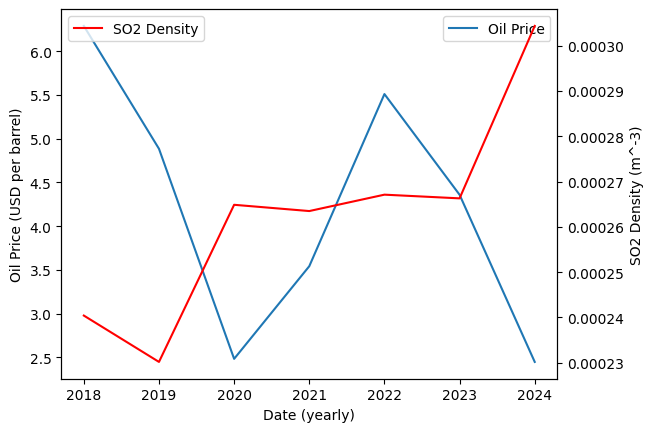

In [ ]:
#twinx plot
fig, ax1 = plt.subplots()

ax1.plot(df_grouped_mean.index, df_grouped_mean['Oil price per barrel'], label='Oil Price')
ax1.legend()
ax1.set_ylabel('Oil Price (USD per barrel)')

ax2 = ax1.twinx()
ax2.plot(df_grouped_mean.index, df_grouped_mean['SO2 density'], label='SO2 Density', color='red')
ax2.set_ylabel('SO2 Density (m^-3)')

# Set the xlabel on the first axes (ax1)
ax1.set_xlabel('Date (yearly)')

ax2.legend()
plt.show()


#Perform some econometrics to see if oil prices can relate to SO2 emission

In [21]:
# we bring in stats model to help with econometric analysis
# we use an AutoRegressive model as we think that oil prices have a lasting
# impact on how power plants operate from quarter to quarter
from statsmodels.tsa.ar_model import AutoReg

In [22]:
# Select the dependent variable (SO2 density)
y = df['SO2_column_number_density']

# Fit the autoregression model with lag order 2, we say the previous two
# quarters will effect the current quarter of SO2 emissions
model = AutoReg(y, lags=2, exog=df['Close']).fit()

# Print the model summary
print(model.summary())

                                AutoReg Model Results                                
Dep. Variable:     SO2_column_number_density   No. Observations:                   25
Model:                          AutoReg-X(2)   Log Likelihood                 182.643
Method:                      Conditional MLE   S.D. of innovations              0.000
Date:                       Wed, 16 Oct 2024   AIC                           -355.285
Time:                               07:04:44   BIC                           -349.608
Sample:                           06-30-2019   HQIC                          -353.857
                                - 12-31-2024                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.0006   7.67e-05      7.757      0.000       0.000       0.001
SO2_column_number_den

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


## Checking for spurious regression

In order to check for spurious regression we perform the following analysis according to Hendry, Explaining Cointegration Analysis: Part 1, International Journal of Energy Economics.

1) Assume that data is non-stationary but can be co-integrated by taking it's differencs

2) Model the change in SO2 as a function of the change in Oil Prices

3) test the model in 2) to see if it is spurious by performing the Augmented-Dicky Fuller (ADF) test on it's residuals

4) If passes Augmented-Dicky Fuller test, remodel the model in 2) using an error corrected model based on it's residuals

5) Check to see if this model is valid via R^2 and F-statistic results and ADF test

6) Now we can model SO2 as a function of Oil Prices


## 1) Assume that data can be co-integrated by taking it's differences  

In [ ]:
model_diff = AutoReg(y.diff().dropna(), lags=2, exog=df['Close'].diff().dropna()).fit()
print(model_diff.summary())

                                AutoReg Model Results                                
Dep. Variable:     SO2_column_number_density   No. Observations:                   24
Model:                          AutoReg-X(2)   Log Likelihood                 167.878
Method:                      Conditional MLE   S.D. of innovations              0.000
Date:                       Mon, 14 Oct 2024   AIC                           -325.756
Time:                               22:01:13   BIC                           -320.301
Sample:                           09-30-2019   HQIC                          -324.471
                                - 12-31-2024                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1.025e-06   2.55e-05      0.040      0.968   -4.89e-05     5.1e-05
SO2_column_number_den

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


## 2) Run the Augmented Dicky Fuller test on the residuals

If p < 0.5 we can say that the data is co-integratable

In [ ]:
#now we get the residuals as we want to perform the a co-integration test to check for
#spurious corrleation, i.e the data we regress on is non-stationary
#thus giving a nonsense regression
#our null hypothesis is that the data we are regressing is stationary

#we perform an augmented Dicky-Fuller test on the residuals
#as described by
#Hendry, Explaining Cointegration Analysis: Part 1, International Journal of Energy Economics

residuals = model_diff.resid

from statsmodels.tsa.stattools import adfuller

result = adfuller(residuals)

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -4.772971067994888
p-value: 6.124456081279639e-05
Critical Values: {'1%': -3.859073285322359, '5%': -3.0420456927297668, '10%': -2.6609064197530863}


p is practically zero! the data is co-integratable!

## 3) now we provide an error corrected differnces model using lagged residuals to see if the model is still valid

In [ ]:
#write model as an error corrected first differences model

#define the independnet variables
exog = pd.concat([df['Close'].diff().dropna(), model.resid.shift(1).dropna()], axis=1).dropna()

print(exog.shape)
print(y.diff().dropna().shape)

model_diff_corrected = AutoReg(y.diff().dropna()[2:], lags=2, exog=exog).fit()
print(model_diff_corrected.summary())

(22, 2)
(24,)
                                AutoReg Model Results                                
Dep. Variable:     SO2_column_number_density   No. Observations:                   22
Model:                          AutoReg-X(2)   Log Likelihood                 161.380
Method:                      Conditional MLE   S.D. of innovations              0.000
Date:                       Mon, 14 Oct 2024   AIC                           -310.760
Time:                               22:36:07   BIC                           -304.786
Sample:                           03-31-2020   HQIC                          -309.594
                                - 12-31-2024                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1.755e-05   1.76e-05      0.996      0.319    -1.7e-05    5.21e-05
SO2_col

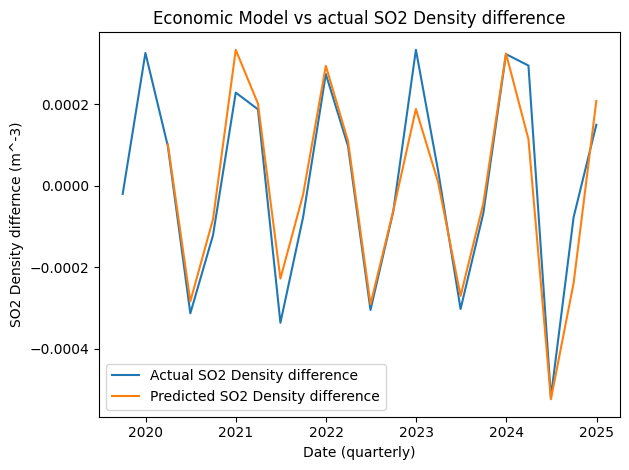

In [ ]:
#plot model_diff with y diff
plt.plot(df.index[3:], y.diff().dropna()[2:], label='Actual SO2 Density difference')
plt.plot(df.index[3:], model_diff_corrected.predict(), label='Predicted SO2 Density difference')
plt.xlabel('Date (quarterly)')
plt.ylabel('SO2 Density differnce (m^-3)')
plt.title('Economic Model vs actual SO2 Density difference')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/economic_model_diff.pdf')
plt.show()

### check if the model by exists by looking at the following:

- Its R^2 test ie. how well does it predict the actual values
- Its Durbin Watson Test
- Its Augmented Dicky Fuller Test ie is it a spurious regresssion?

In [ ]:
#calculate the R2 value
from sklearn.metrics import r2_score

# Create mask for valid data points (non-NaN)
# mask states indices by finding all values that do not have nan's is them
# valid_mask = ~(False | True) = False


predicitons = model_diff_corrected.predict() #+ model.resid
# Filter y and predictions based on the mask
y_valid = y.diff().dropna()
predictions_valid = predicitons.dropna()#[valid_mask]

r2 = r2_score(y_valid[4:], predictions_valid)

print(r2)


0.9047363273672466


In [ ]:
#apply durbin watson test
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model_diff_corrected.resid)


1.7661590432619934

If Durbin watson result is 2 within 0.01 degrees of error then there is no auto correlation. 1.77 is almost 2 but not close enough thus the model is slightly unsound, indicating it is missing some explanatory variables.

In [ ]:
# apply ADF test on error corrected model this will be a strong indication of whether or not our
# model is co-integrateable and thus has some meaningful relation

result = adfuller(model_diff_corrected.resid)

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.65156494348041
p-value: 0.004848380202448241
Critical Values: {'1%': -3.8326031418574136, '5%': -3.0312271701414204, '10%': -2.655519584487535}


p-value < 0.5 thus we can say the model is co-integrable!

## 4) We decide that the model is good enough, oil prices clearly are playing a role in

Let's look at our model and run some simple analysis!

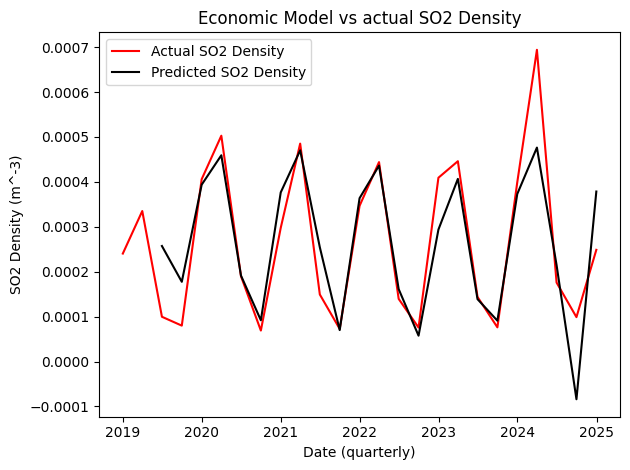

In [24]:
plt.plot(df.index, y, label='Actual SO2 Density',color='red')
plt.plot(df.index, model.predict(), label='Predicted SO2 Density',color="black")
plt.xlabel('Date (quarterly)')
plt.ylabel('SO2 Density (m^-3)')
plt.title('Economic Model vs actual SO2 Density')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/economic_model.pdf')
plt.show()

In [ ]:
#how does our model via the R^2 test?

predicitons = model.predict()
# Filter y and predictions based on the mask
y_valid = y.dropna()
predictions_valid = predicitons.dropna()#[valid_mask]

r2 = r2_score(y_valid[2:], predictions_valid)

print(r2)

0.7615446952424996


In [ ]:
#how does our model line up with the DW test?

durbin_watson(model.resid)

1.9249325646518514

Over all our model fit could be improved however the durbin watson test is even closer to saying errors have no autocorrelation. Therefore our model is pretty good but needs some explanatory varaibles.

What is clearly missing is non-athropogenic SO2 emissions as the atmosphre readings do not discrimiante between what is released from fires and what is relased from fossil fuel buring.

We also could maybe consider number of cooling and heating days as there are seasonal trends and how coal prices respond direclty to SO2 emissions.

#### Let us look at our model residuals!

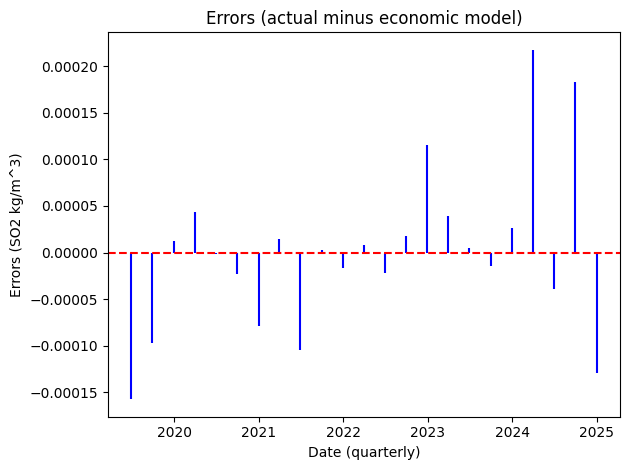

In [24]:
#plot residuals

# Assuming 'model' is your fitted statsmodels model
residuals = model.resid

# Create the stem plot so we can see how far the residuals are from 0
plt.stem(df.index[2:], residuals, markerfmt=' ', linefmt='b-', basefmt=' ')

plt.xlabel('Date (quarterly)')
plt.ylabel('Errors (SO2 kg/m^3)')
plt.title('Errors (actual minus economic model)')
plt.axhline(y=0, color='red', linestyle='--') #highlight the zero line

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/residuals.pdf')

plt.show()

In [ ]:
#We reject that errors are normally distirbuted if p < 0.05

#Shapiro-Wilks test
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(residuals)

# Print the results
print('Shapiro-Wilk Statistic:', statistic)
print('p-value:', p_value)

Shapiro-Wilk Statistic: 0.926050510169054
p-value: 0.08987504922457086
